# Throughput

This report investigates the efficiency of each ESIS optical component
and estimates the total sensitivity of the optics (not including the sensor).

To accomplish this,
we trace a grid of rays through the system and compute the ratios of the intensity
of the unvignetted rays.
This allows us to compute the average efficiency over the whole FOV,
instead of just the on-axis efficiency.


In [1]:
import matplotlib.pyplot as plt
import astropy.visualization
import named_arrays as na
import esis

Load the optical design

In [2]:
instrument = esis.flights.f1.optics.design_single(num_distribution=0)
instrument.wavelength = na.linspace(-1, 1, axis="wavelength", num=101)

Trace rays through the optical design

In [3]:
rays = instrument.system.raytrace().outputs

/home/runner/.local/lib/python3.12/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Create a list with the names of each surface

In [4]:
surface_names = [s.name for s in instrument.system.surfaces_all]

Isolate the name of the logical axis indicating different surfaces

In [5]:
axis_surface = instrument.system.axis_surface

Compute the index of each surface

In [6]:
index_source = 0
index_primary = surface_names.index(instrument.primary_mirror.surface.name)
index_grating = surface_names.index(instrument.grating.surface.name)
index_filter = surface_names.index(instrument.filter.surface.name)

Compute the intensity of the rays at each surface

In [7]:
axis_sum = instrument.field.axes + instrument.pupil.axes
kwargs_sum = dict(
    axis=axis_sum, 
    where=rays.unvignetted[{axis_surface: ~0}],
)
intensity_source = rays.intensity[{axis_surface: index_source}].sum(**kwargs_sum)
intensity_primary = rays.intensity[{axis_surface: index_primary}].sum(**kwargs_sum)
intensity_grating = rays.intensity[{axis_surface: index_grating}].sum(**kwargs_sum)
intensity_filter = rays.intensity[{axis_surface: index_filter}].sum(**kwargs_sum)

Compute the efficiency of each surface by taking intensity ratios

In [8]:
efficiency_primary = intensity_primary / intensity_source
efficiency_grating = intensity_grating / intensity_primary
efficiency_filter = intensity_filter / intensity_grating
efficiency_total = intensity_filter / intensity_source

/home/runner/.local/lib/python3.12/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Plot the efficiencies as a function of wavelength.

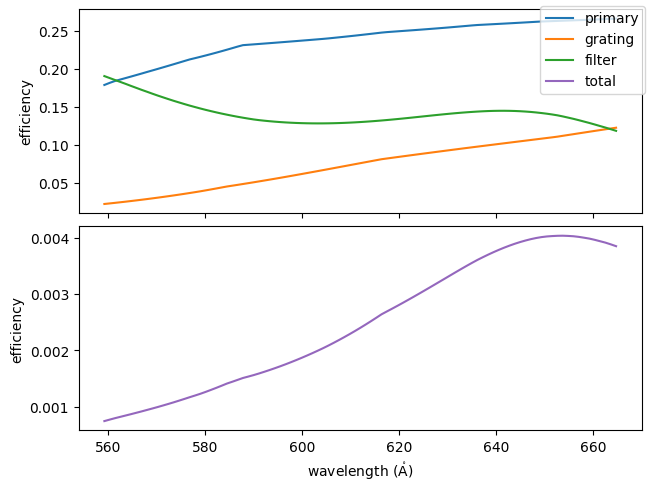

In [9]:
with astropy.visualization.quantity_support():
    fig, ax = plt.subplots(
        nrows=2,
        sharex=True,
        constrained_layout=True,
    )
    na.plt.plot(
        instrument.wavelength_physical,
        efficiency_primary,
        ax=ax[0],
        label=instrument.primary_mirror.surface.name,
        color="tab:blue",
    )
    na.plt.plot(
        instrument.wavelength_physical,
        efficiency_grating,
        ax=ax[0],
        label=instrument.grating.surface.name,
        color="tab:orange",
    )
    na.plt.plot(
        instrument.wavelength_physical,
        efficiency_filter,
        ax=ax[0],
        label=instrument.filter.surface.name,
        color="tab:green",
    )
    na.plt.plot(
        instrument.wavelength_physical,
        efficiency_total,
        ax=ax[1],
        label="total",
        color="tab:purple",
    )
    fig.legend()
    ax[1].set_xlabel(f"wavelength ({ax[1].get_xlabel()})")
    ax[0].set_ylabel("efficiency")
    ax[1].set_ylabel("efficiency")

Plot a schematic of the three multilayer stacks to compare

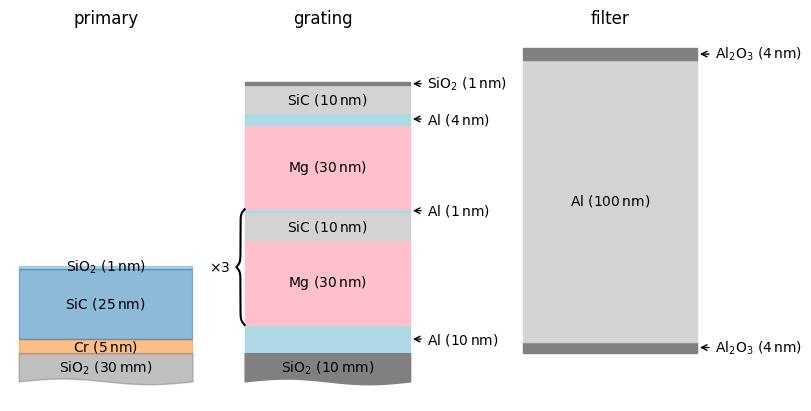

In [10]:
with astropy.visualization.quantity_support():
    fig, ax = plt.subplots(
        ncols=3,
        sharey=True,
        figsize=(8,4),
        constrained_layout=True,
    )
    instrument.primary_mirror.material.plot_layers(ax=ax[0])
    instrument.grating.material.plot_layers(ax=ax[1])
    instrument.filter.material.plot_layers(ax=ax[2])
    ax[0].set_title(instrument.primary_mirror.surface.name)
    ax[1].set_title(instrument.grating.surface.name)
    ax[2].set_title(instrument.filter.surface.name)
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()
    ax[2].autoscale()